# TVB for Epilepsy


### Basic configurations

In [1]:
# !source activate python2.7.3
!source activate python2_7

%matplotlib inline

import resource 
resource.setrlimit(resource.RLIMIT_NOFILE, (1000, -1))

import sys
stdout = sys.stdout

import os

import numpy as np
from tvb_epilepsy.base.constants.config import Config
from tvb_epilepsy.base.utils.log_error_utils import initialize_logger
from tvb_epilepsy.io.tvb_data_reader import TVBReader
from tvb_epilepsy.io.h5_reader import H5Reader
from tvb_epilepsy.io.h5_writer import H5Writer
from tvb_epilepsy.plot.plotter import Plotter

input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "tvb")
head_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "Head")
# input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "INS", "TREC", "TREC88HH")
# head_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "INS", "TREC", "TREC88HH", "Head")
output_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "notebook", "realistic")
config = Config(head_folder=input_folder, output_base=output_folder, data_mode="tvb") #, data_mode="java"
config.hypothesis.head_folder = head_folder
config.figures.MATPLOTLIB_BACKEND="inline"
config.figures.SHOW_FLAG=True
logger = initialize_logger(__name__, config.out.FOLDER_LOGS)
reader = TVBReader() if config.input.IS_TVB_MODE else H5Reader()
writer = H5Writer()
plotter = Plotter(config)
sys.stdout = stdout

# BASIC WORKFLOW 

### Read data from tvb or Head folder

In [2]:
### Reading data
logger.info("Reading from: " + config.input.HEAD)
head = reader.read_head(config.input.HEAD, seeg_sensors_files=[("seeg_xyz.txt",)])
# Plot
# plotter.plot_head(head)

### Generate an hypothesis by manual definition 

In [3]:
# logger.info("\n\Reading hypothesis from file...")        
# lsa_hypothesis = reader.read_hypothesis(hypothesis_file)

# Formulate a VEP hypothesis manually
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder

hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config)

# Regions of Pathological Excitability hypothesis:
x0_indices = [2, 24]
x0_values = [0.2, 0.2]
hyp_builder.set_x0_hypothesis(x0_indices, x0_values)

# Regions of Model Epileptogenicity hypothesis:
e_indices = [1, 26]
e_values = np.array([0.99, 0.99])
hyp_builder.set_e_hypothesis(e_indices, e_values)

# Regions of Connectivity hypothesis:
w_indices = [] # [(0, 1), (0, 2)] 
w_values = [] # [0.5, 2.0] 
# hypo_builder.set_w_indices(w_indices).set_w_values(w_values)

hypothesis = hyp_builder.set_normalize(1.5).build_hypothesis()

### ...or by reading from epileptogenicity file...

In [ ]:
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder
# Read clinical hypothesis 
hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config).set_normalize(0.99)
e_indices = [1, 26]# [1, 2, 25, 26]
hypothesis = hyp_builder.build_hypothesis_from_file("clinical_hypothesis_postseeg", e_indices) 
# Change something manually if necessary
hypothesis.x0_values = [0.01, 0.01]

### Print hypothesis

In [4]:
disease_indices = hypothesis.regions_disease_indices
disease_values = hypothesis.regions_disease_values
w_indices = hypothesis.connectivity_disease_indices
w_values = hypothesis.connectivity_disease_values
n_w = len(w_indices)
n_e = len(e_indices)
n_disease = len(disease_indices)
n_x0 = n_disease - n_e
all_regions_indices = np.array(range(head.number_of_regions))
healthy_indices = np.delete(all_regions_indices, disease_indices).tolist()
n_healthy = len(healthy_indices)
print(hypothesis)
print(hypothesis.string_regions_disease(head.connectivity.region_labels))
print(hypothesis.string_connectivity_disease(head.connectivity.region_labels))

DiseaseHypothesis{
01. Name = e_x0_Hypothesis
02. Type = Excitability_Epileptogenicity
03. Number of regions = 87
04. Excitability (x0) disease indices = [2, 24]
05. Excitability (x0) disease values = [0.30303030303030304, 0.30303030303030304]
06. Epileptogenicity (E) disease indices = [1, 26]
07. Epileptogenicity (E) disease values = [1.5, 1.5]
08. Connectivity (W) disease indices = []
09. Connectivity (W) disease values = []
10. Propagation indices = []
11. Propagation strengths of indices = []}
1. ctx-lh-caudalanteriorcingulate: E=1.5
2. ctx-lh-caudalmiddlefrontal: x0=0.30303030303
24. ctx-lh-rostralanteriorcingulate: x0=0.30303030303
26. ctx-lh-superiorfrontal: E=1.5



### Generate model configuration from hypothesis

1: E=1.5
2: x0=0.30303030303
24: x0=0.30303030303
26: E=1.5
K = 1.14943
x0_max = -0.925311343706
x0_min = -2.46018558934
x1eq_max = -1.16667
x1eq_min = -1.66663


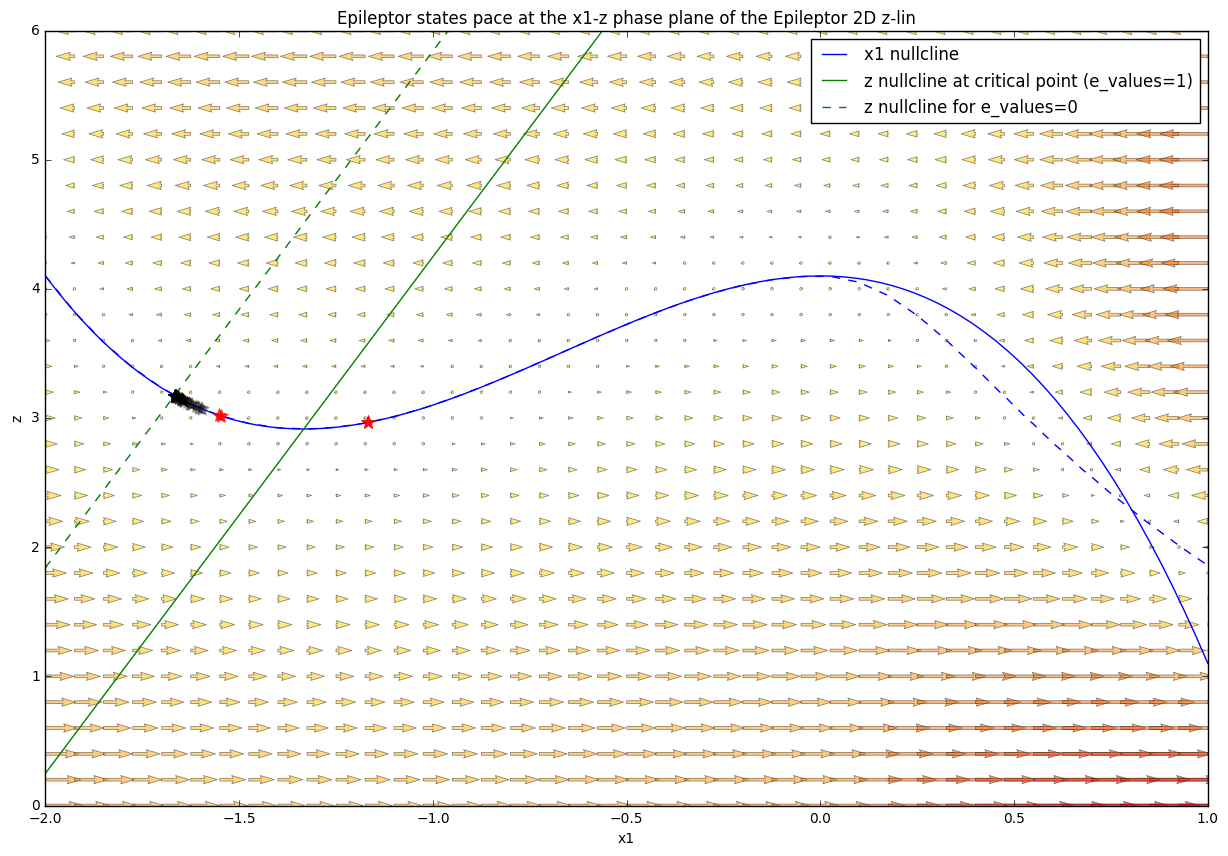

In [30]:
# logger.info("\n\nReading model configuration from file...")
# model_configuration = reader.read_model_configuration(model_config_file)

from tvb_epilepsy.service.model_configuration_builder import ModelConfigurationBuilder
from tvb_epilepsy.base.constants.model_constants import K_DEF

logger.info("\n\nRunning hypothesis: " + hypothesis.name)
logger.info("\n\nCreating model configuration...")
# K = 3*K_DEF # in the case of the above hypothesis read from file
K = K_DEF #3! in the case of the above manual hypothesis
model_config_builder = ModelConfigurationBuilder(hypothesis.number_of_regions, K=K)
mcs_file = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_model_config_service.h5")
writer.write_model_configuration_builder(model_config_builder, mcs_file)
print(hypothesis.string_regions_disease())
# Assume all healthy nodes have x0_values = 0.0:
model_configuration = model_config_builder.build_model_from_hypothesis(hypothesis, head.connectivity.normalized_weights)
# # Assume all healthy nodes have e_values = 0.0
# model_configuration = model_config_builder.build_model_from_E_hypothesis(hypothesis, head.connectivity.normalized_weights)
print "K =", np.mean(model_configuration.K)
print "x0_max =", np.max(model_configuration.x0)
print "x0_min =", np.min(model_configuration.x0)
print "x1eq_max =", np.max(model_configuration.x1eq)
print "x1eq_min =", np.min(model_configuration.x1eq)
mc_path = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_ModelConfig.h5")
writer.write_model_configuration(model_configuration, mc_path)
# Plot nullclines and equilibria of model configuration
plotter.plot_state_space(model_configuration, "2D", head.connectivity.region_labels, 
                         special_idx=hypothesis.regions_disease_indices, 
                         figure_name=hypothesis.name + "_StateSpace")

# LINEAR STABILITY ANALYSIS

### Run linear stability analysis

DiseaseHypothesis{
01. Name = e_x0_Hypothesis_LSA
02. Type = Excitability_Epileptogenicity
03. Number of regions = 87
04. Excitability (x0) disease indices = [2, 24]
05. Excitability (x0) disease values = [0.2, 0.2]
06. Epileptogenicity (E) disease indices = [1, 26]
07. Epileptogenicity (E) disease values = [0.99, 0.99]
08. Connectivity (W) disease indices = []
09. Connectivity (W) disease values = []
10. Propagation indices = [ 1 26]
11. Propagation strengths of indices = [ 0.41540467  0.60077675]}


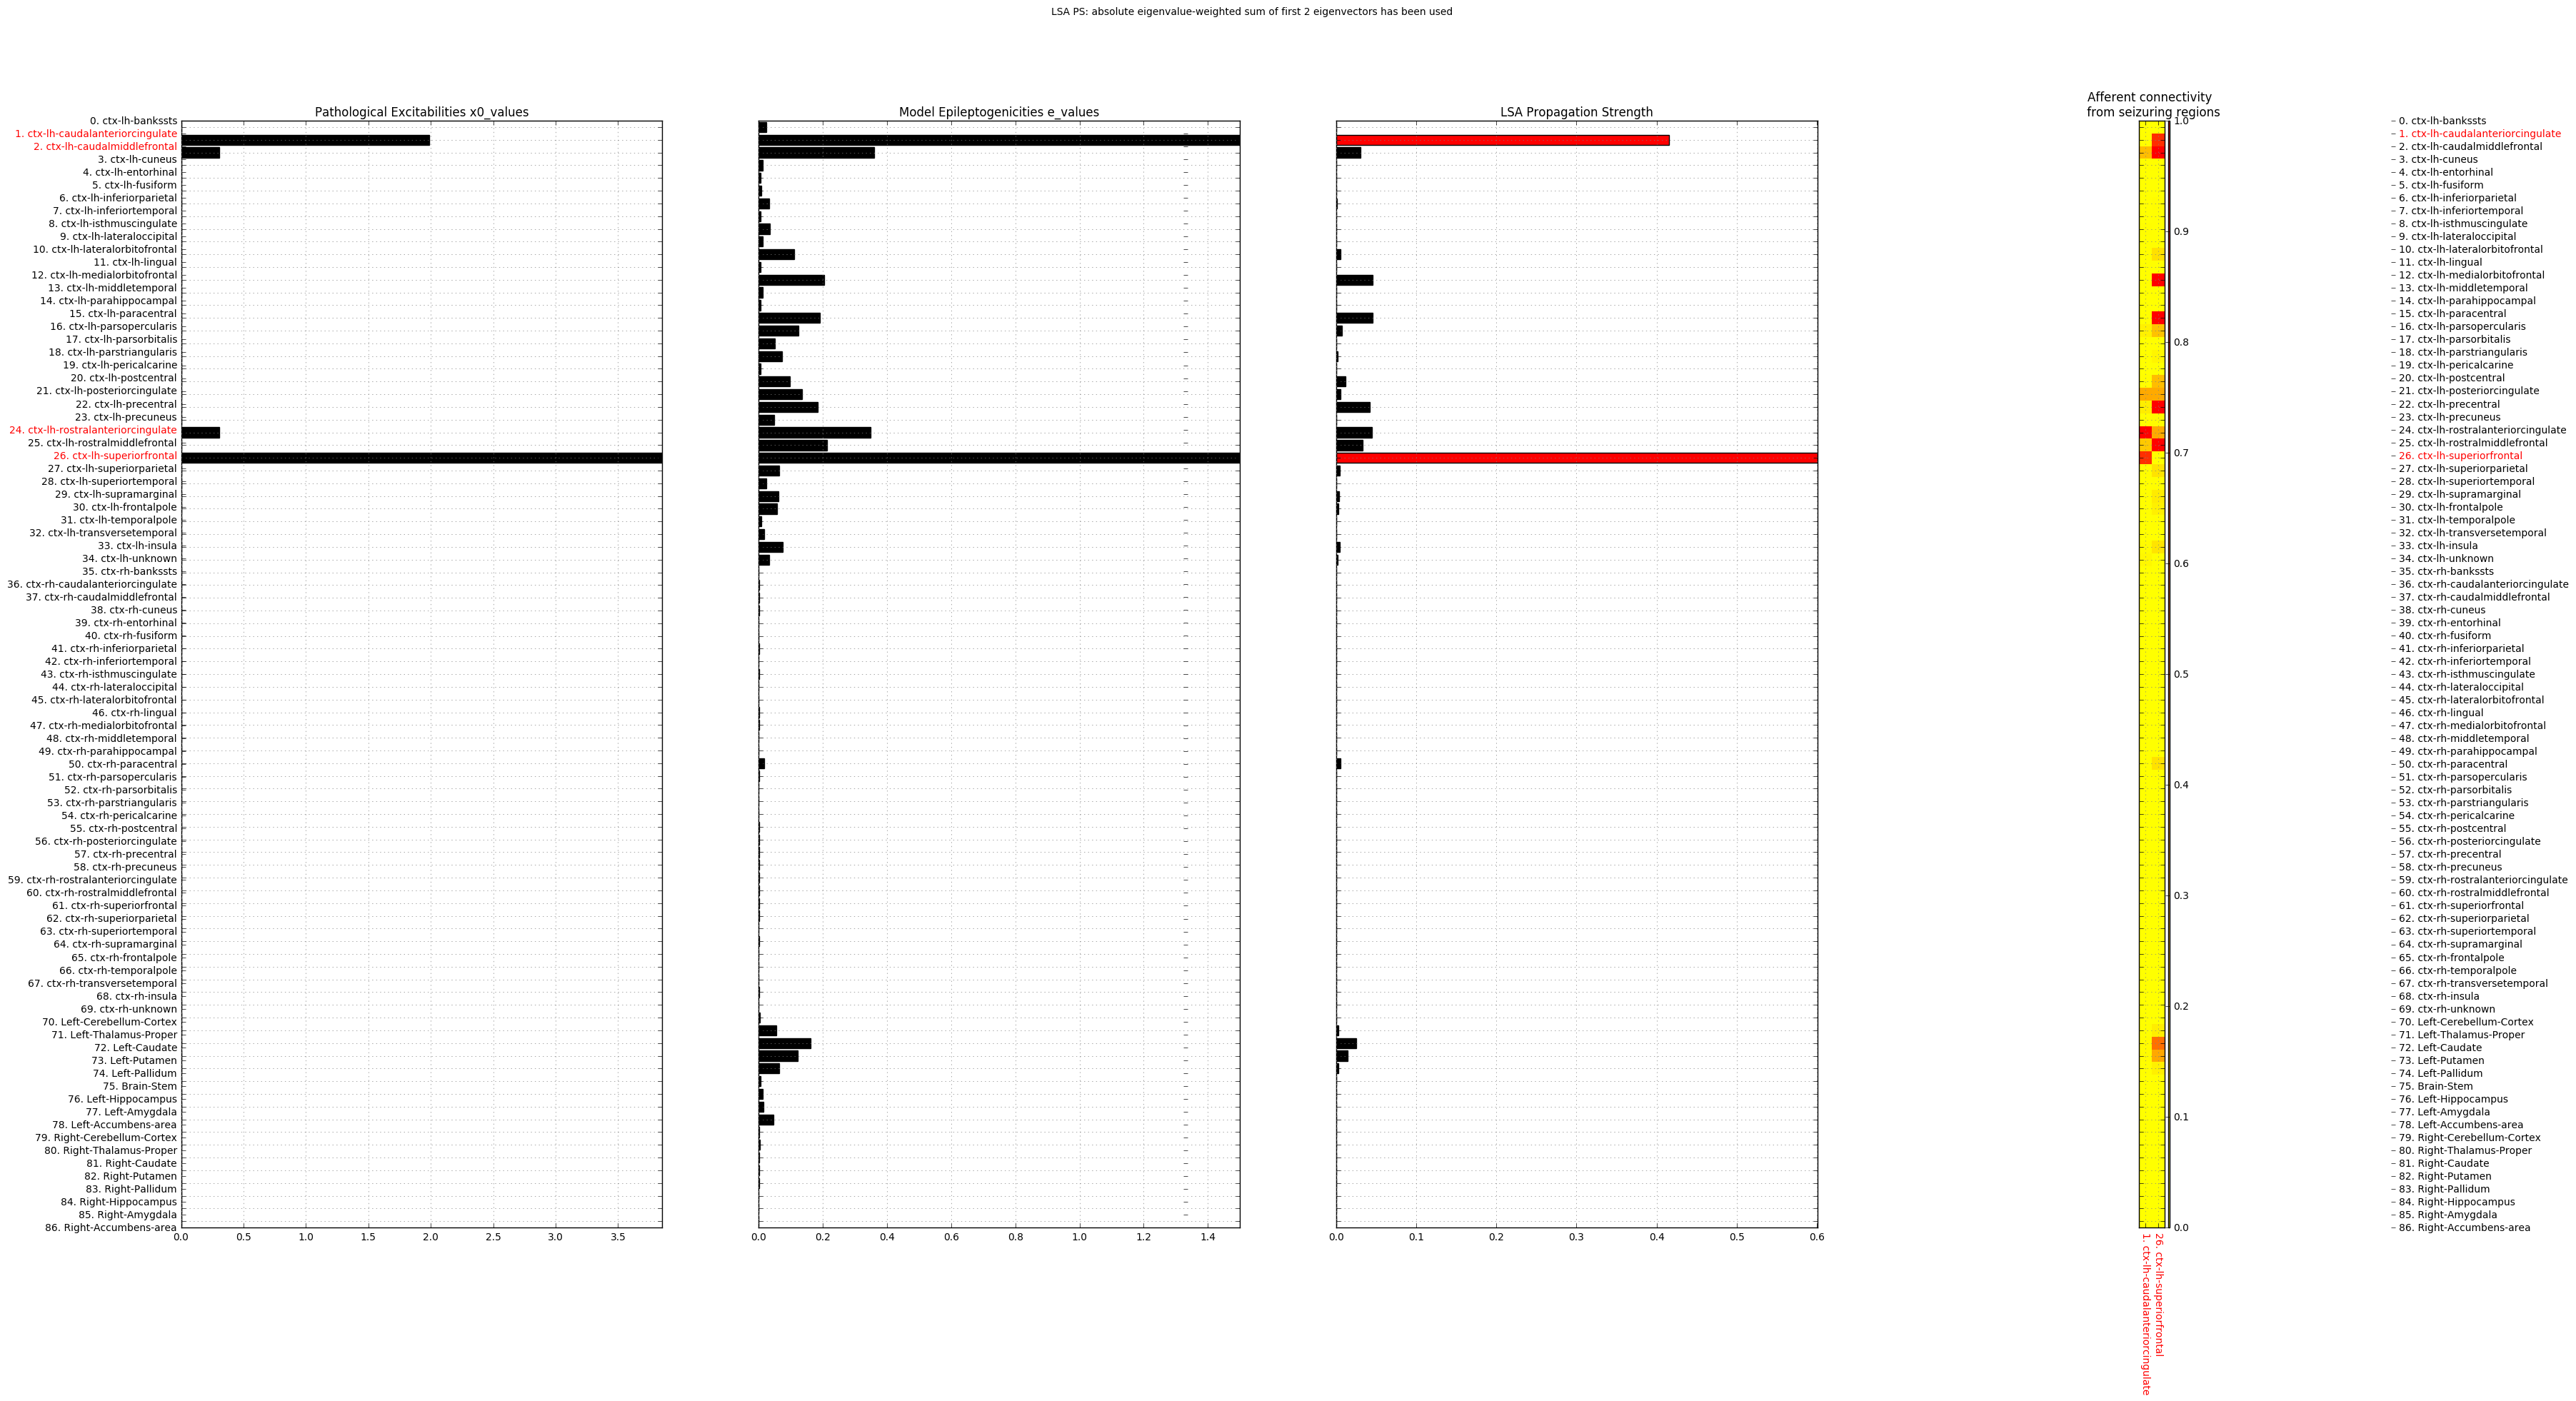

In [31]:
# Run linear stability analysis
# logger.info("\n\Reading LSA hypothesis from file...")        
# lsa_hypothesis = reader.read_hypothesis(lsa_hypothesis_file)
from tvb_epilepsy.service.lsa_service import LSAService
logger.info("\n\nRunning LSA...")
# Options for eigen_vectors_number: 
# "auto_eigenvals": eigenvalues curve elbow point selection,
# "auto_disease": len(n_disease), 
# "auto_epileptogenicity": Model Epileptogenicity curve elbow point selection,
# "auto_excitability": Pathological Excitability curve elbow point selection
# or "user_defined": a number equal to from 1 to hypothesis.number_of_regions
lsa_service = LSAService(eigen_vectors_number=None, 
                         eigen_vectors_number_selection="auto_eigenvals", 
                         weighted_eigenvector_sum=True, 
                         normalize_propagation_strength=False)
lsa_hypothesis = lsa_service.run_lsa(hypothesis, model_configuration)
print(lsa_hypothesis)
lsa_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSA.h5")
lsa_config_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSAConfig.h5")
writer.write_hypothesis(lsa_hypothesis, lsa_path)

# Plot
plotter.plot_lsa(lsa_hypothesis, model_configuration, lsa_service.weighted_eigenvector_sum,
                 lsa_service.eigen_vectors_number, head.connectivity.region_labels, None);

# SIMULATION

### Prepare simulation

In [44]:
from collections import OrderedDict
from tvb_epilepsy.base.model.timeseries import Timeseries, TimeseriesDimensions
from tvb_epilepsy.service.simulator.simulator_builder import SimulatorBuilder
from tvb_epilepsy.top.scripts.simulation_scripts import compute_seeg_and_write_ts_to_h5

# --------------------------Simulation-----------------------------------
sim_type = "tvb" # "realistic" # "tvb" # "paper" 
logger.info("\n\nConfiguring simulation from model_configuration...")
# If you choose model...
# Available models beyond the TVB Epileptor (they all encompass optional variations from the different papers):
# EpileptorDP: similar to the TVB Epileptor + optional variations,
# EpileptorDP2D: reduced 2D model, following Proix et all 2014 +optional variations,
# EpleptorDPrealistic: starting from the TVB Epileptor + optional variations, but:
#      -x0, Iext1, Iext2, slope and K become noisy state variables,
#      -Iext2 and |slope are coupled to z, g, or z*g in order for spikes to appear before seizure,
#      -multiplicative correlated noise is also used
# We don't want any time delays for the moment
head.connectivity.tract_lengths *= 0.0
sim_builder = SimulatorBuilder(config.simulator.MODE)
# sim_settings = reader.read_simulation_settings(sim_settings_file)
# First set model name, then build settings!
report_every_n_monitor_step=100
if sim_type == "realistic":
    model = sim_builder.set_model_name("EpileptorDPrealistic").generate_model_tvb(model_configuration)
    model.tau0 = 10000.0
    model.tau1 = 0.2
    model.slope = 0.25
    model.Iext2 = 0.45
    model.pmode = np.array("z")
    sim_settings = sim_builder.set_fs(4*4096.0).set_fs_monitor(1024.0).set_simulated_period(10000).build_sim_settings()
    from tvb_epilepsy.base.constants.model_constants import COLORED_NOISE
    sim_settings.noise_intensity *= 0.1
    # print(sim_settings.noise_intensity)
    # sim_settings.noise_type = COLORED_NOISE
    # sim_settings.noise_ntau = 10
    report_every_n_monitor_step=1000
elif sim_type == "tvb":
   model = sim_builder.set_model_name("Epileptor").generate_model_tvb(model_configuration)
   # model.tau0 = 10000.0
   # model.tau1 = 0.2
   # model.slope = 0.25
   # model.Iext2 = 0.45
   sim_settings = sim_builder.set_fs(8*4096.0).set_fs_monitor(1024.0).set_simulated_period(5000).build_sim_settings()
   sim_settings.noise_intensity = [0.005, 0.005, 0.01, 0.05, 0.05, 0.01]
else:
   model = sim_builder.generate_model_tvb(model_configuration)
   model.slope = 0.5
   model.Iext2 = 0.45
   sim_settings = sim_builder.build_sim_settings()  # "EpileptorDP" by default

sim, sim_settings, model = sim_builder.build_simulator_TVB_from_model_sim_settings(model_configuration, 
                                                                                   head.connectivity, model, sim_settings)

writer.write_simulation_settings(sim.simulation_settings, os.path.join(config.out.FOLDER_RES, 
                                                                       hypothesis.name + "_SimSettings.h5"))
writer.write_generic(model, os.path.join(config.out.FOLDER_RES, hypothesis.name + "_" + 
                                             model._ui_name + "_SimModel.h5"))


### SIMULATE!

...100.0% done in 102.491275072 secs

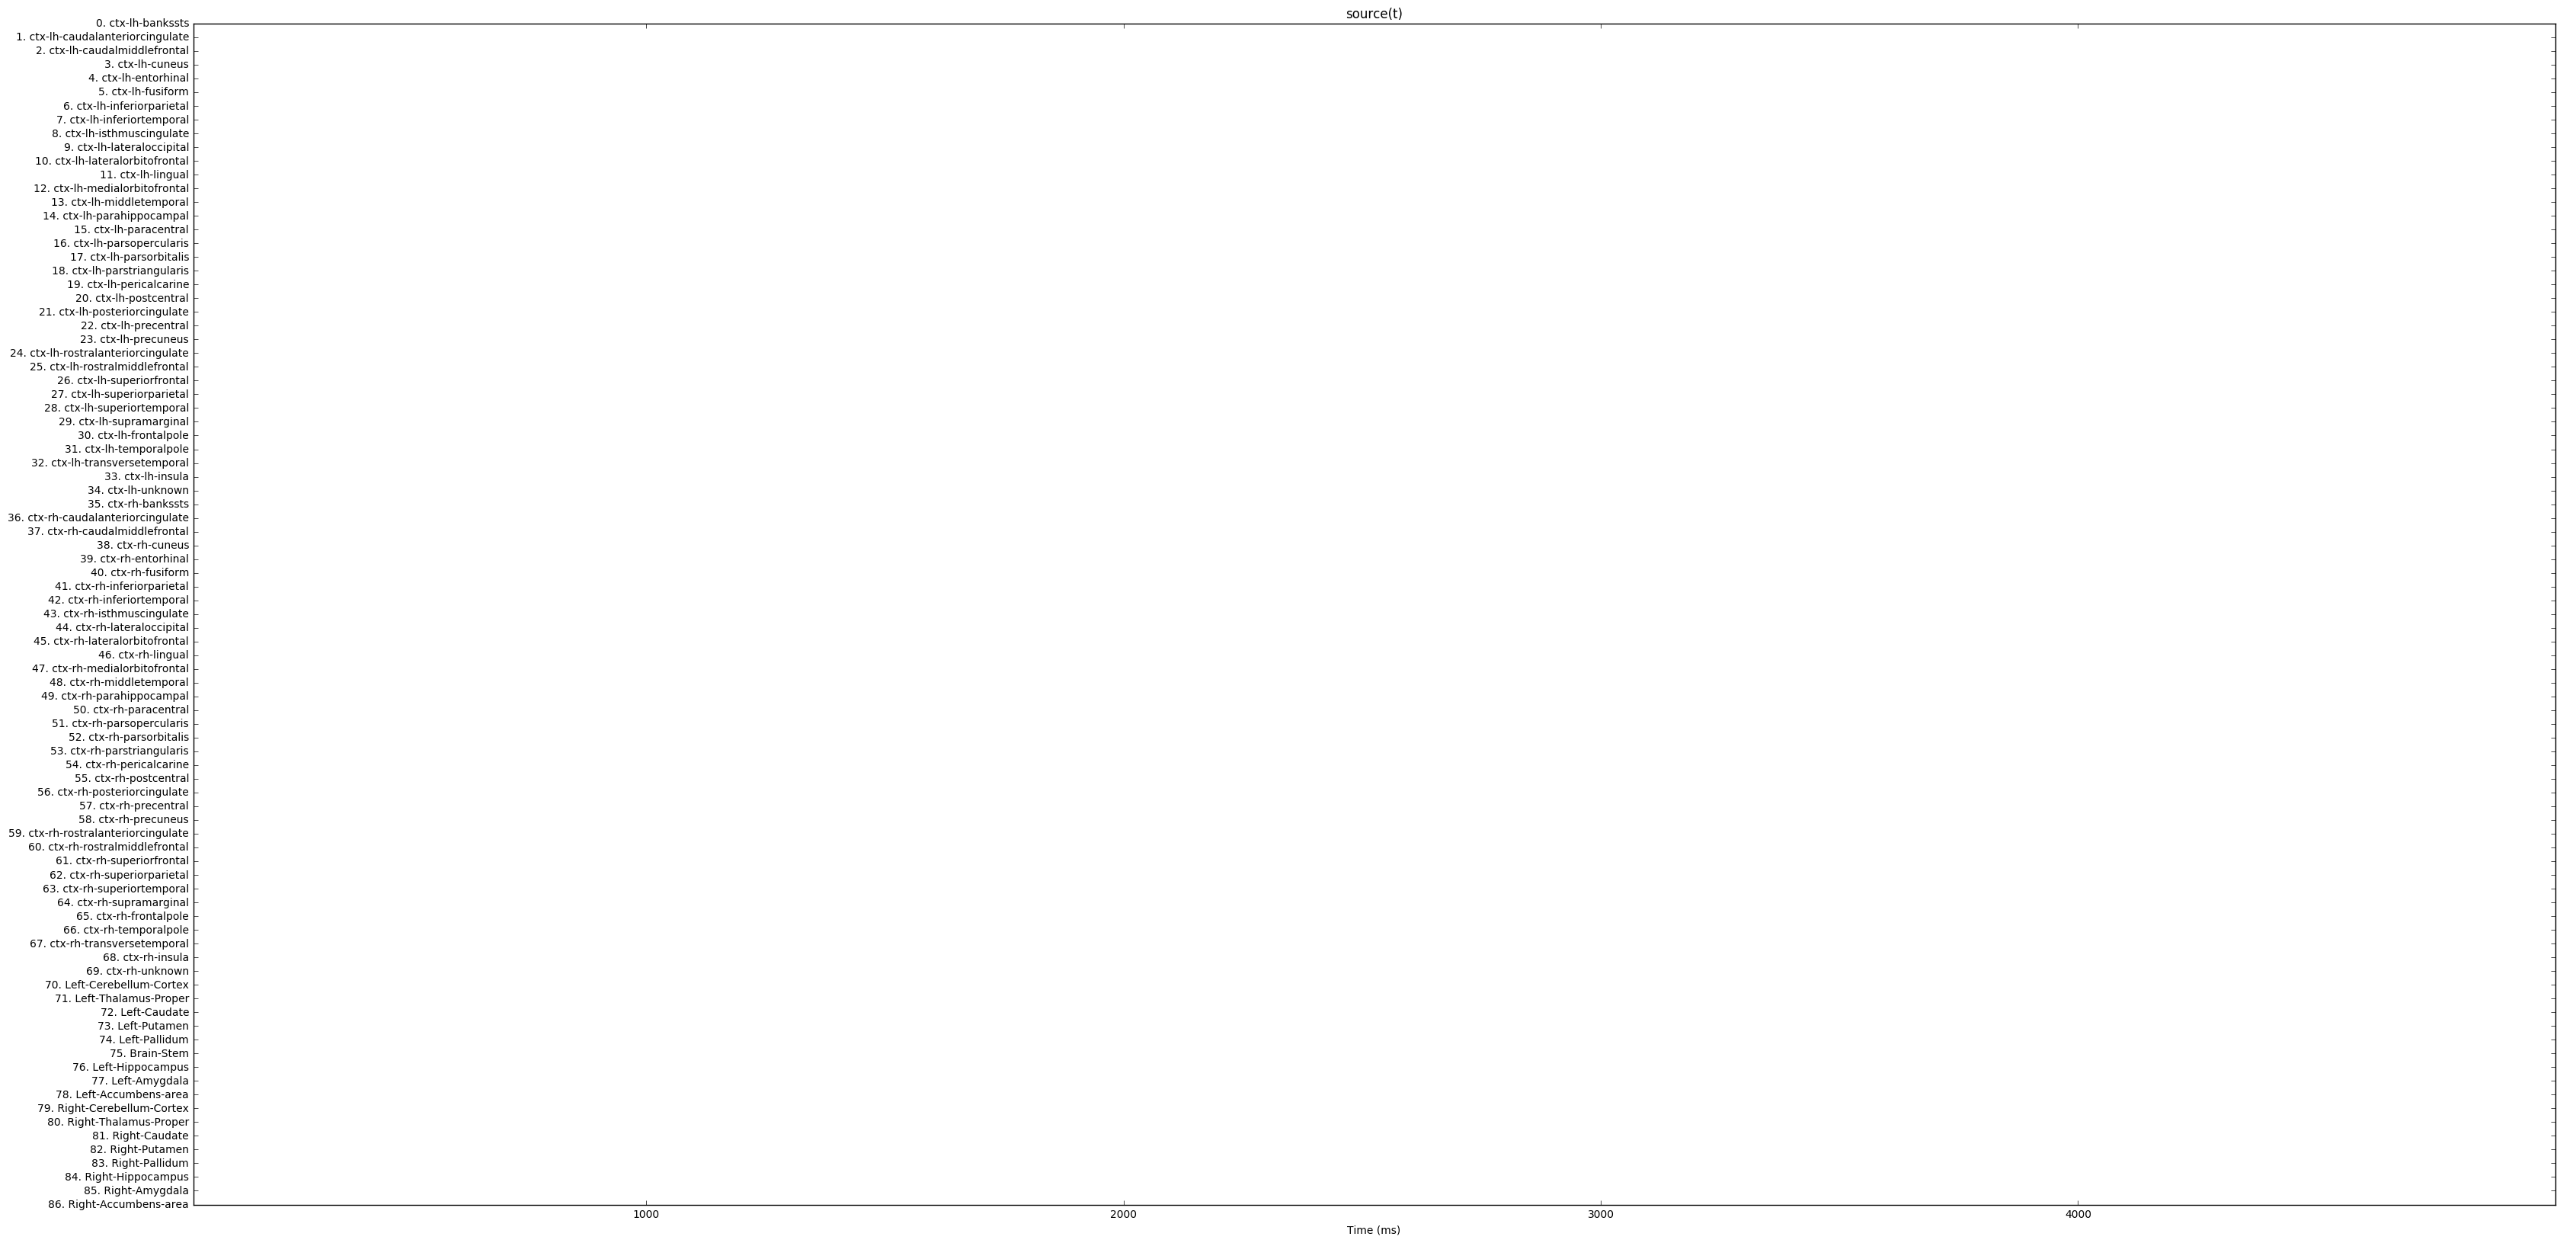

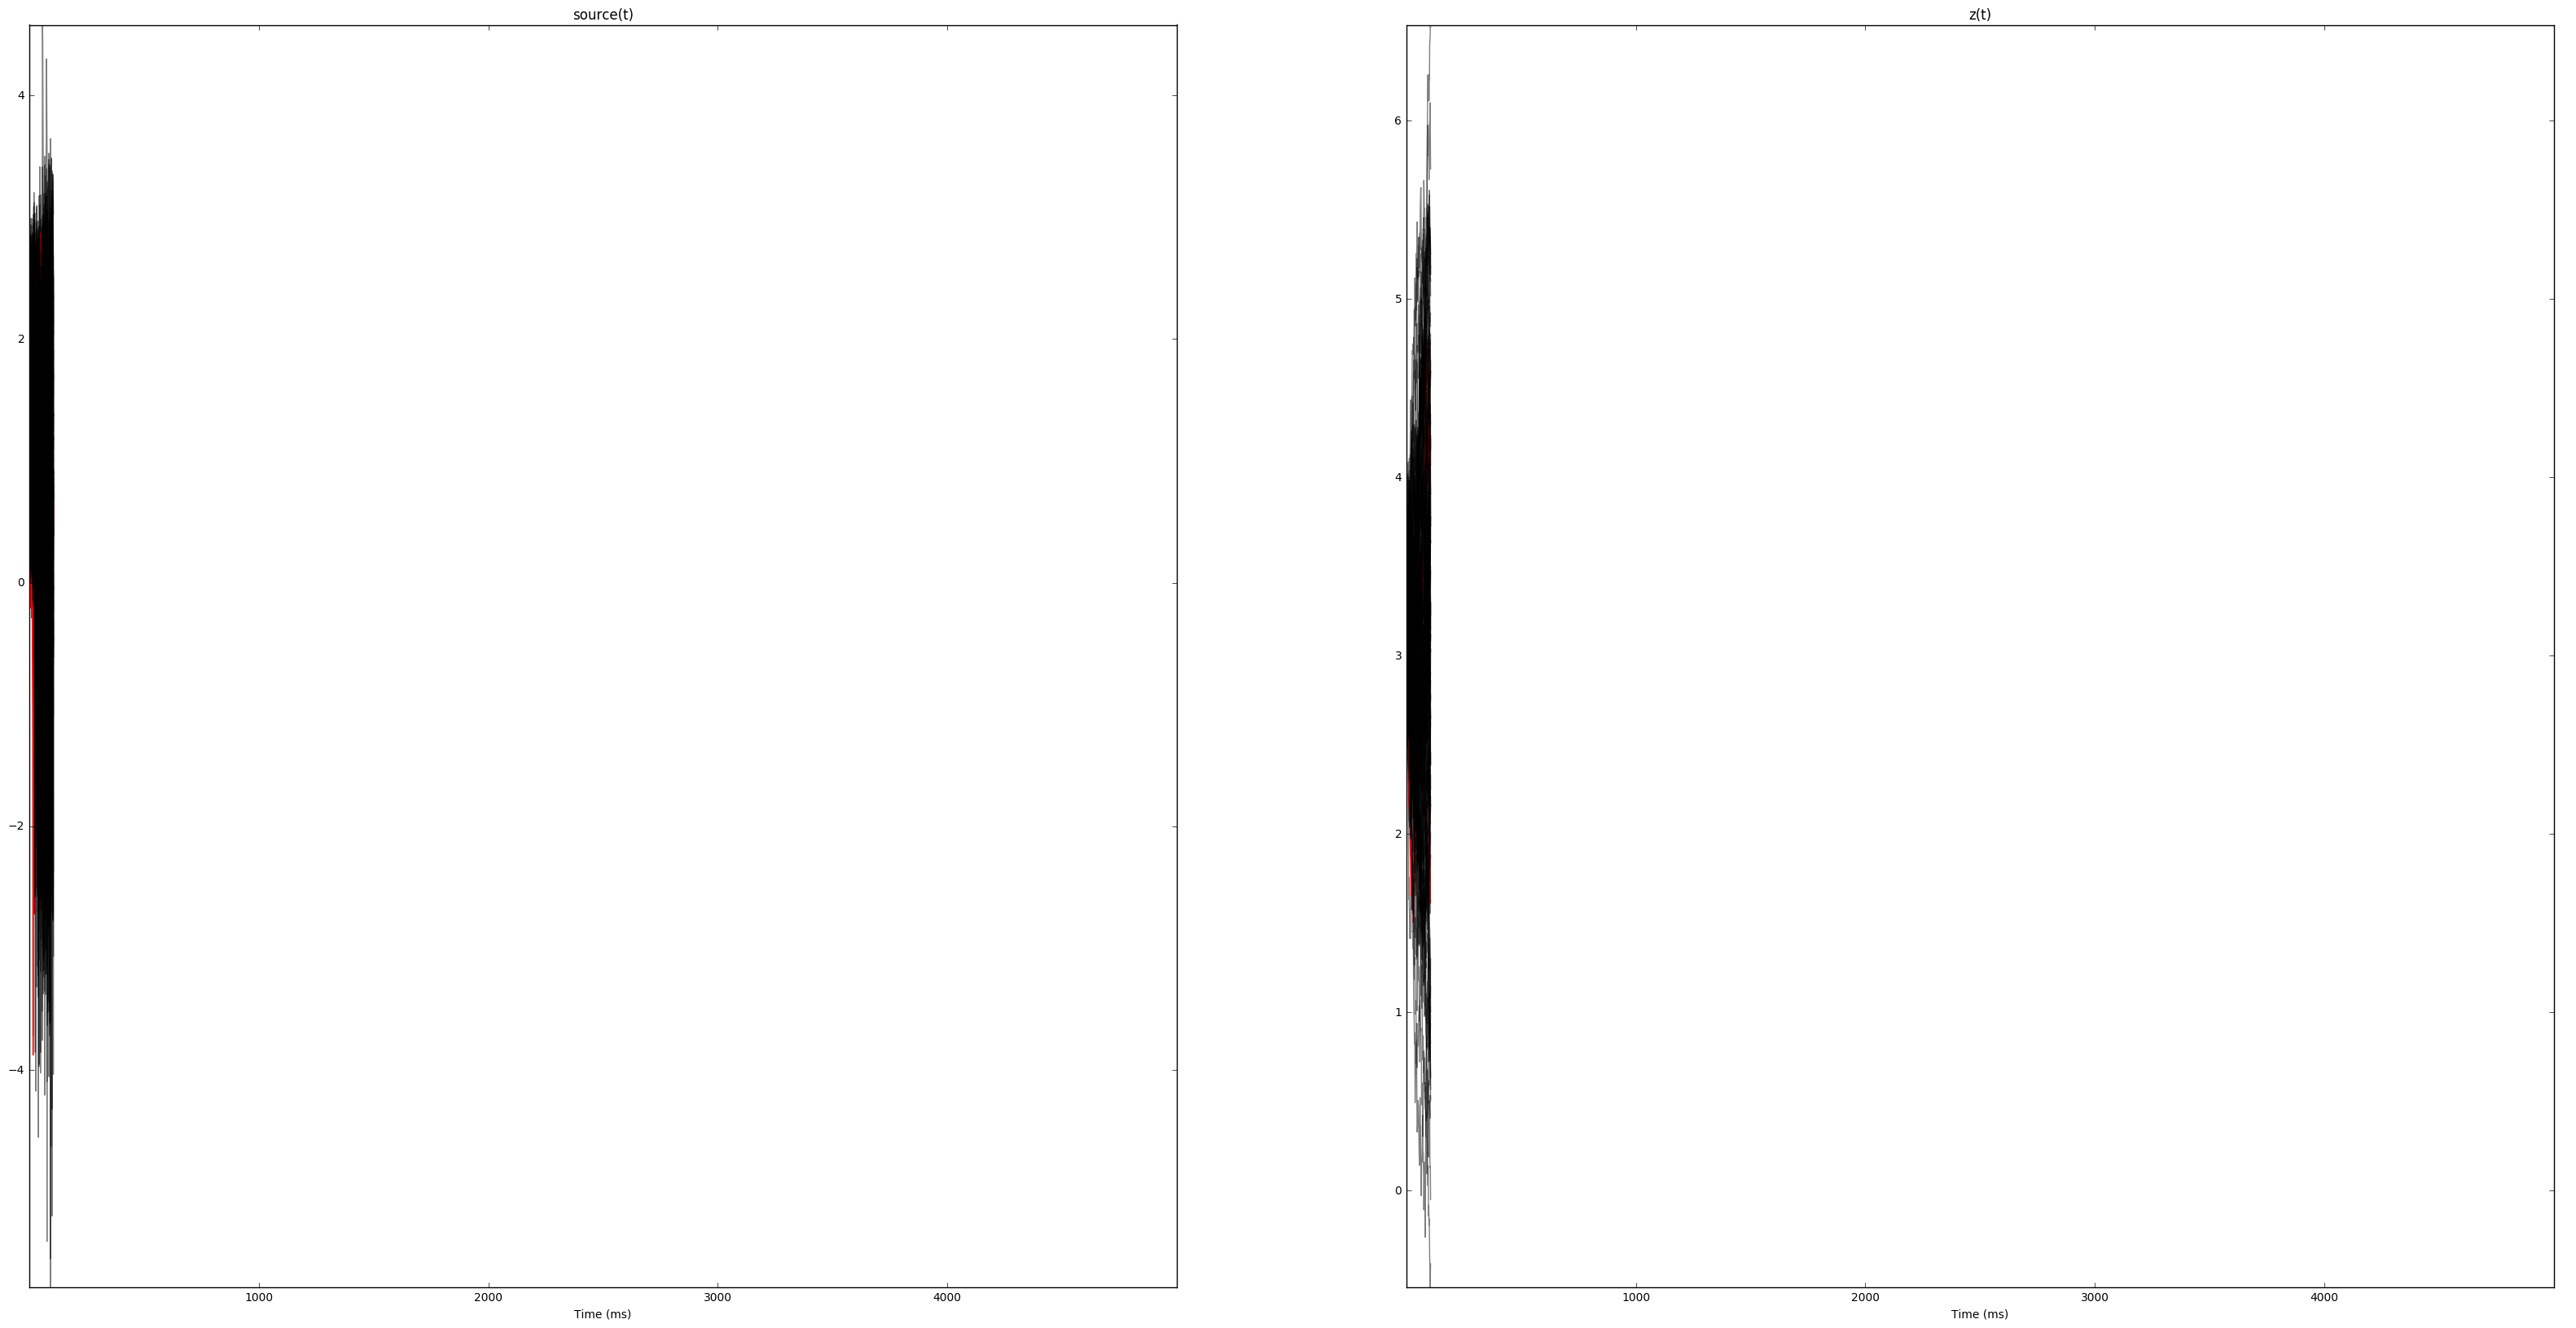

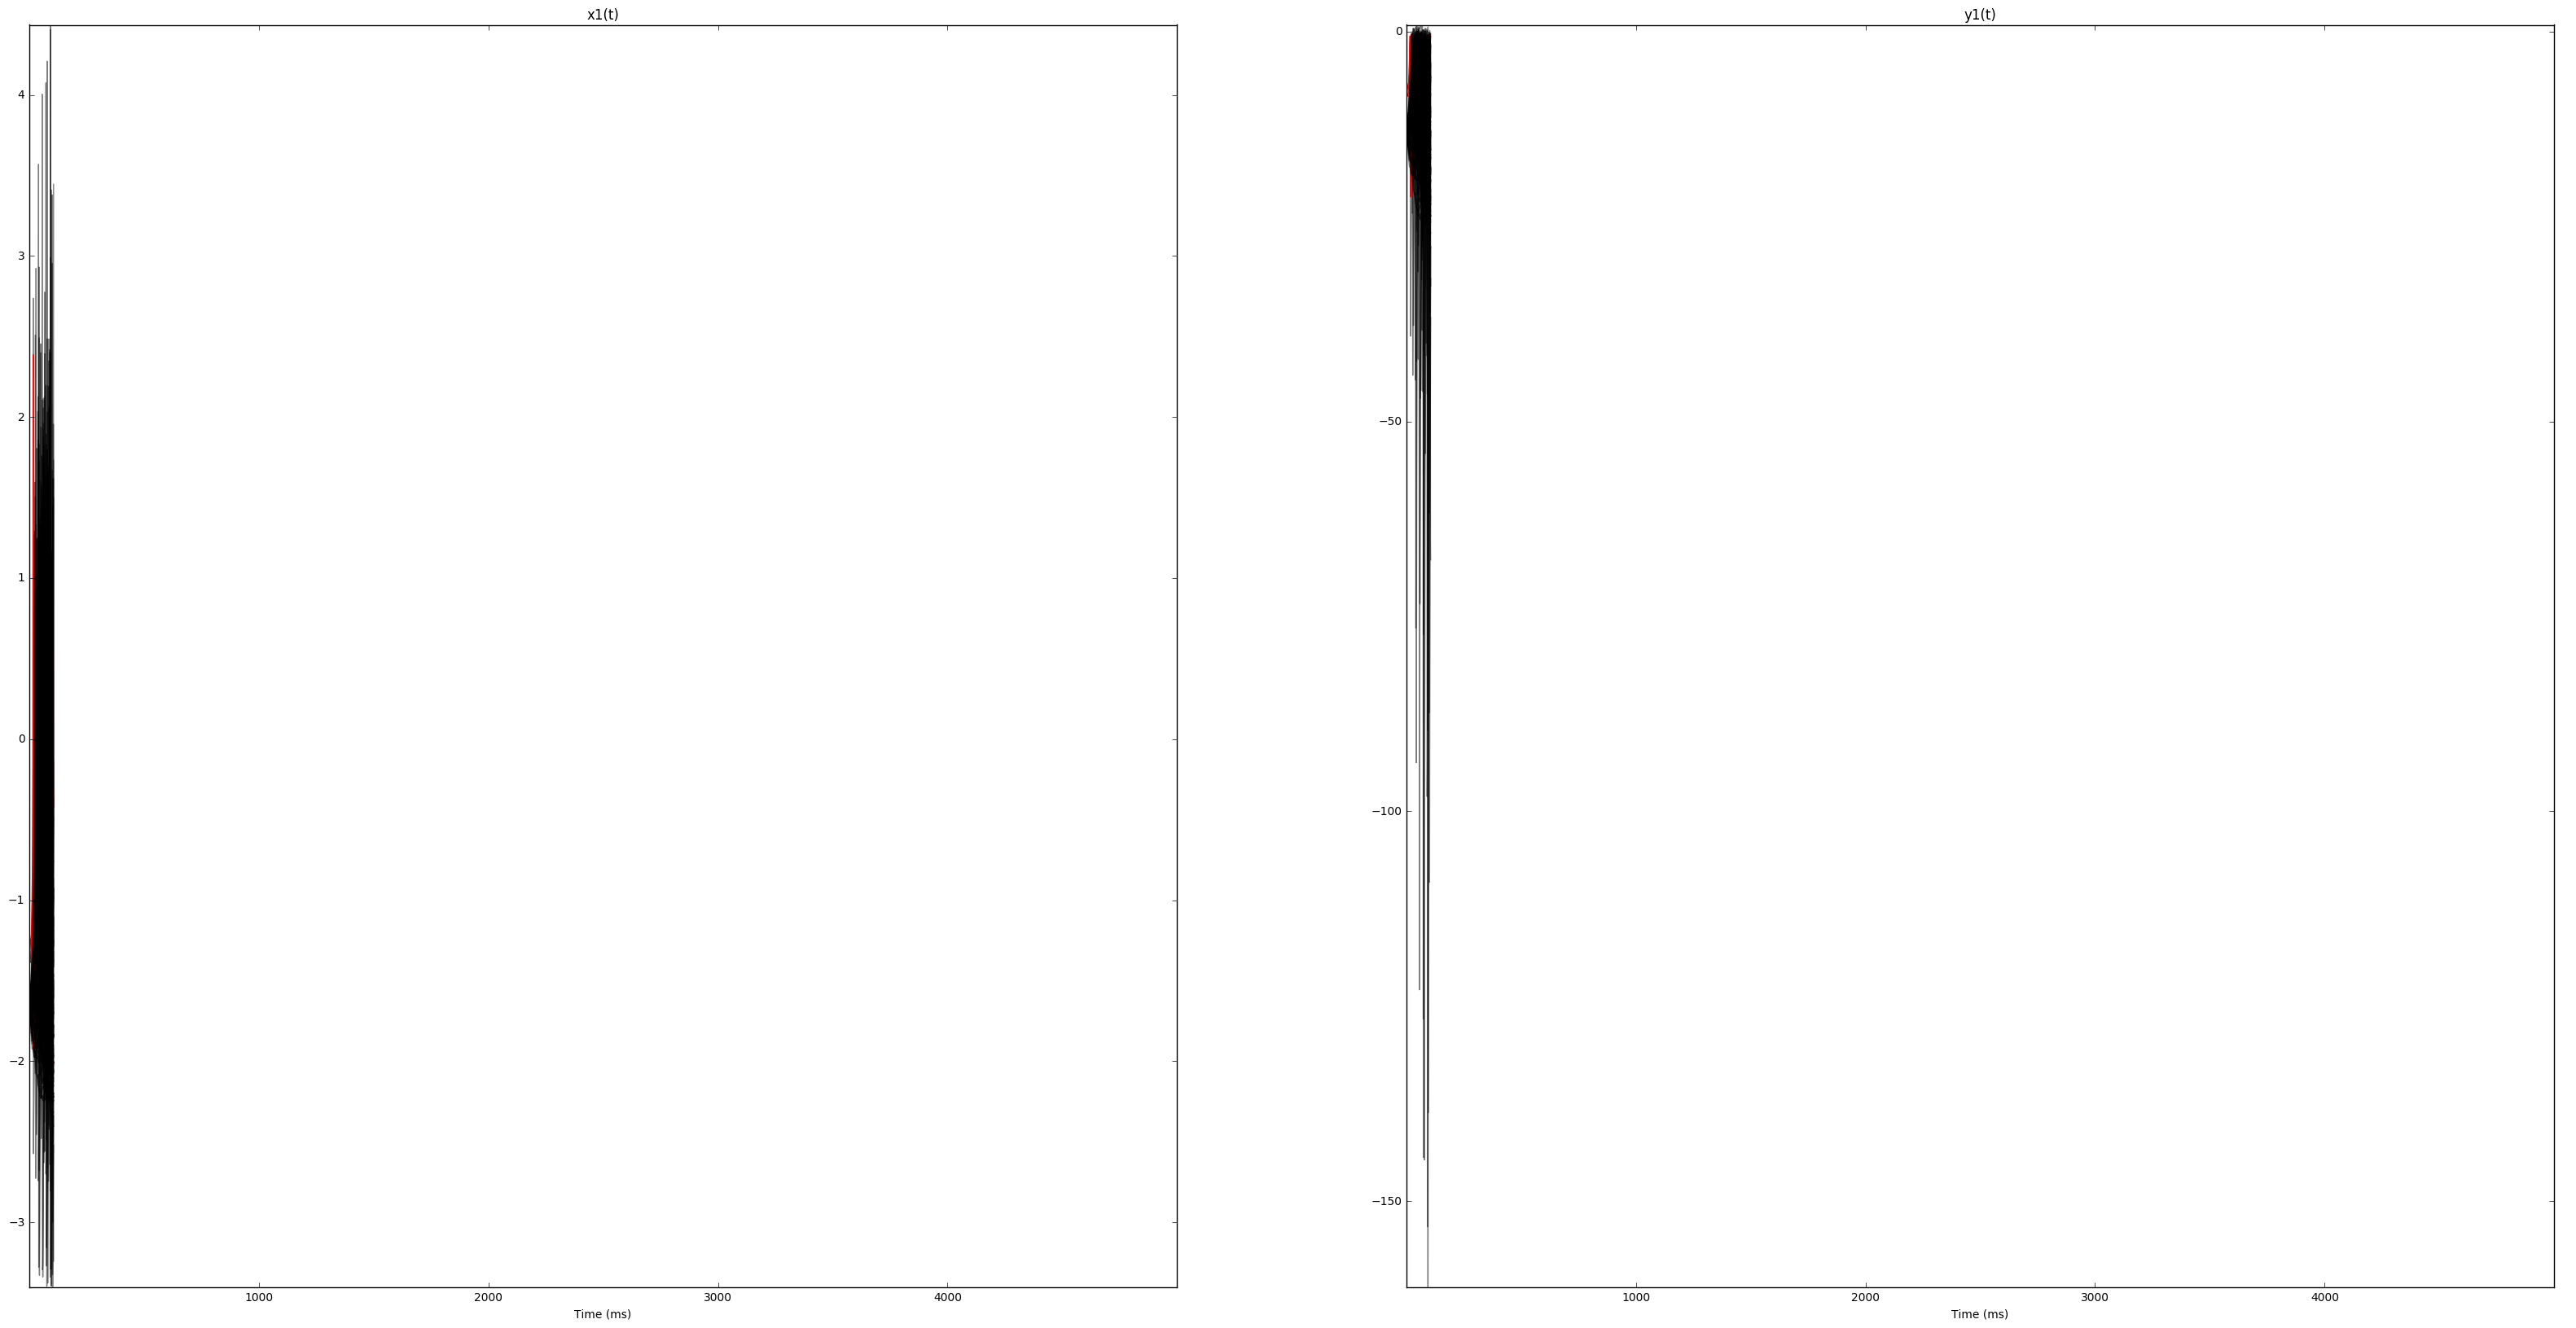

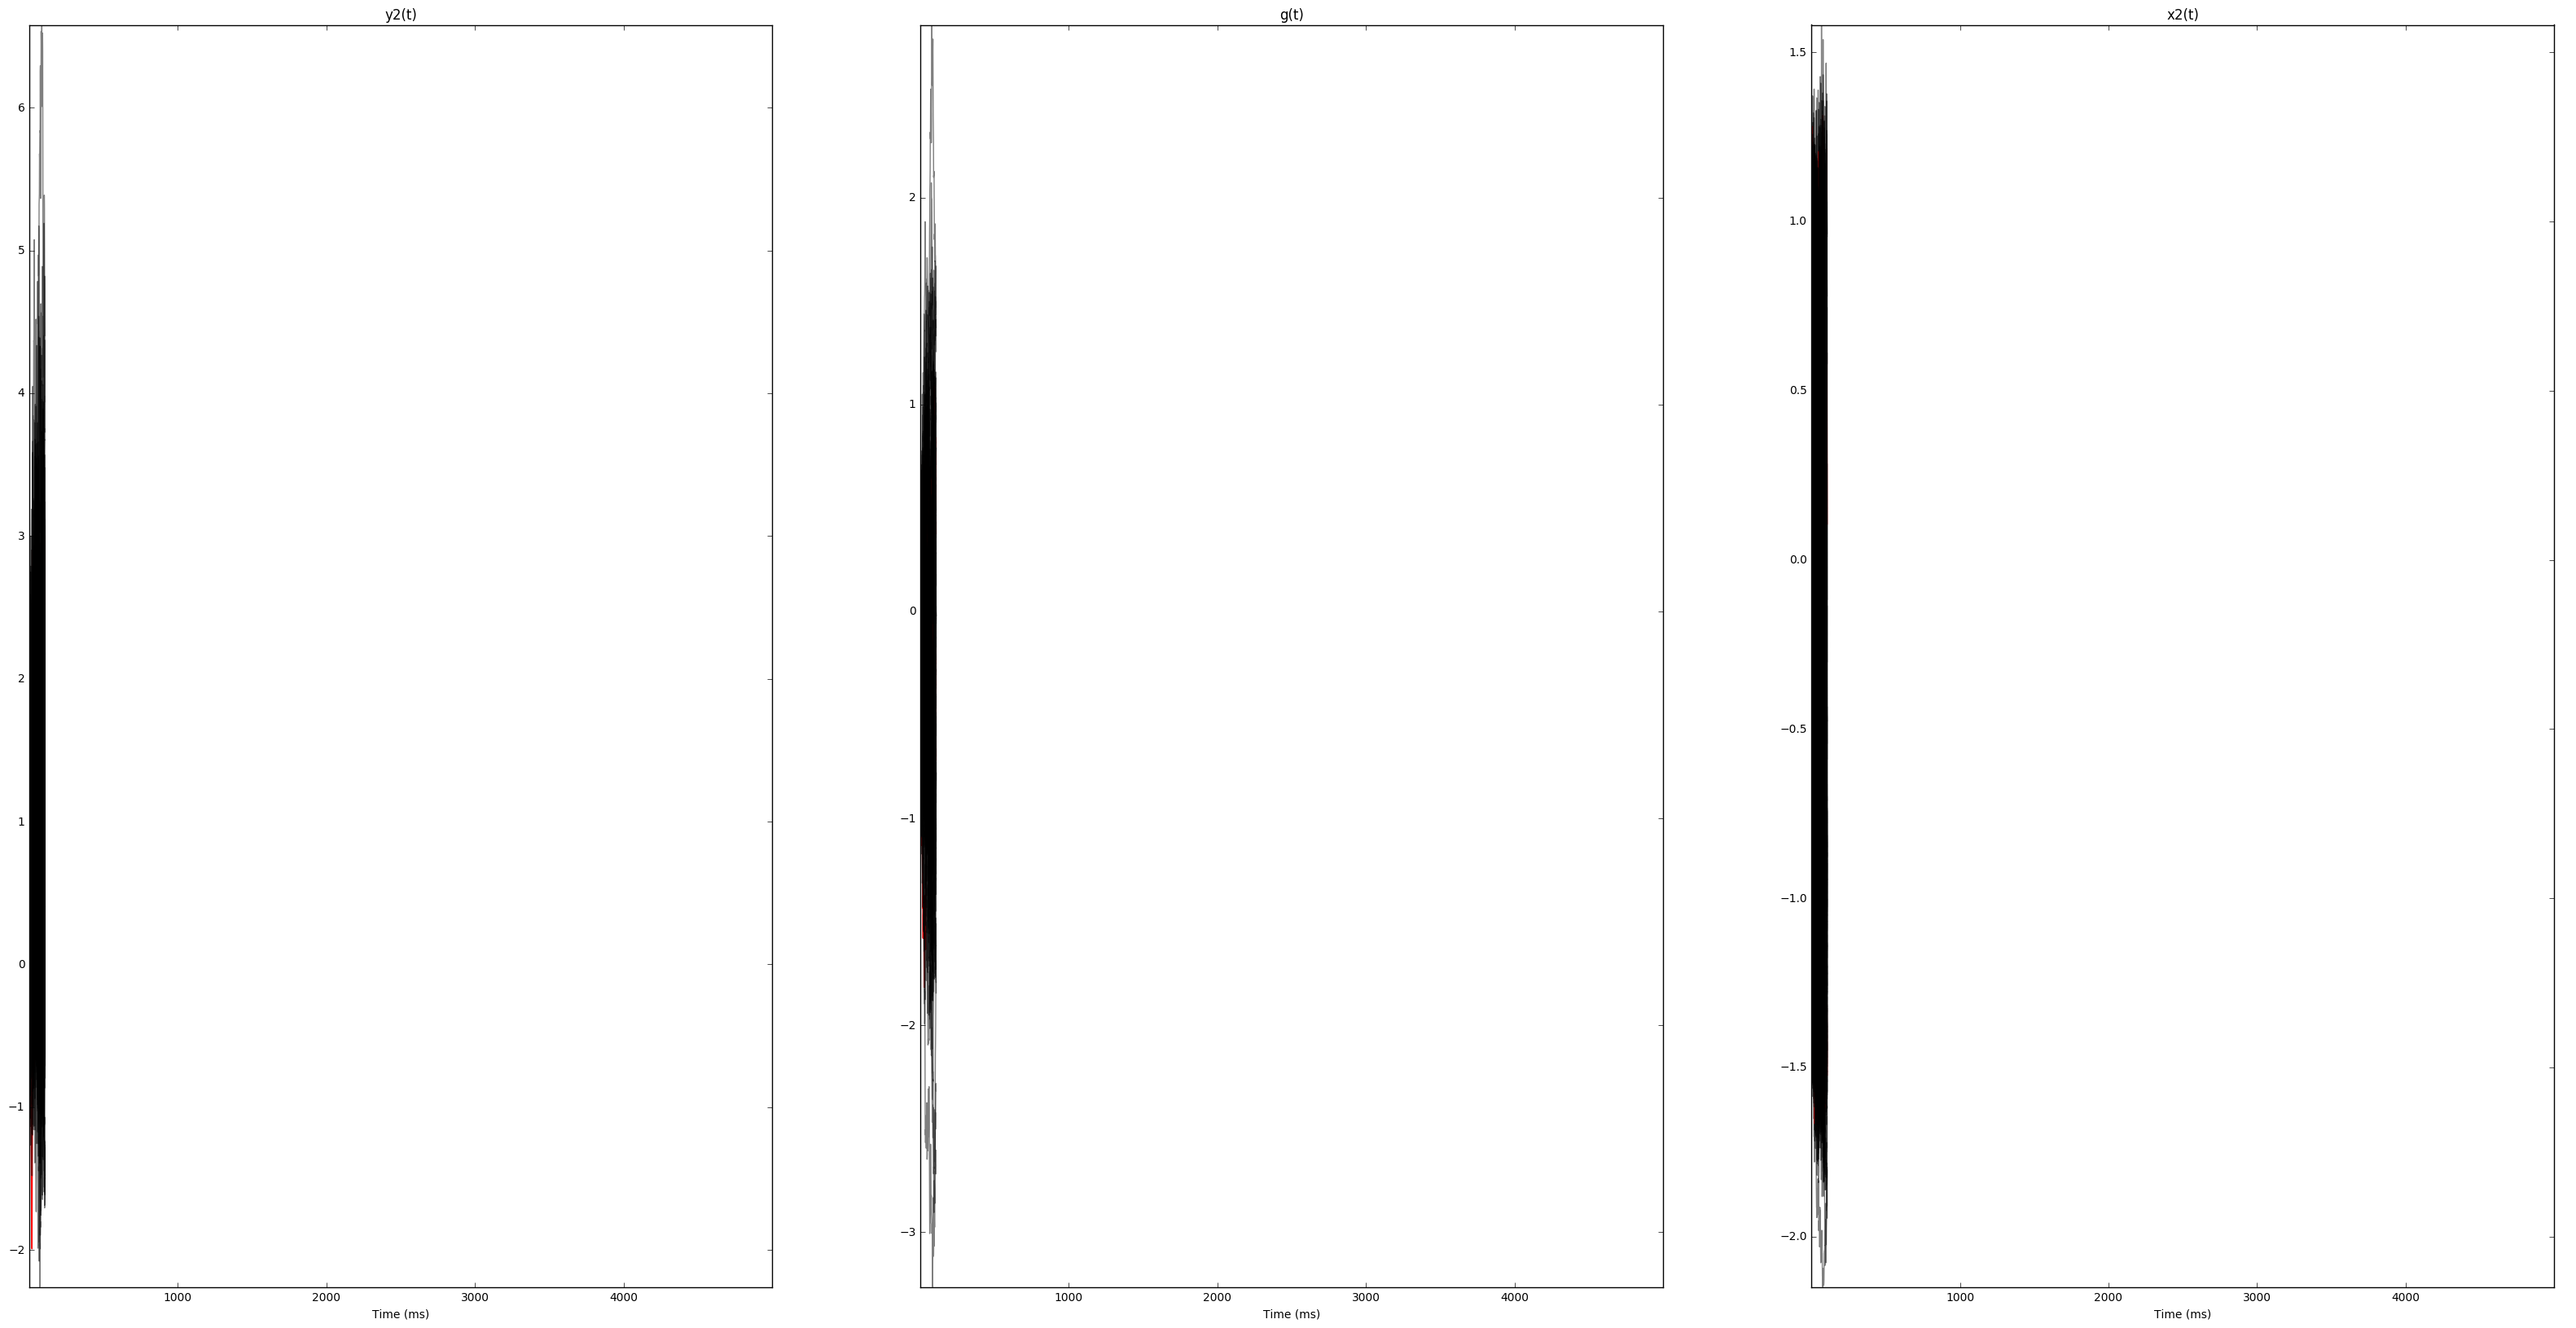

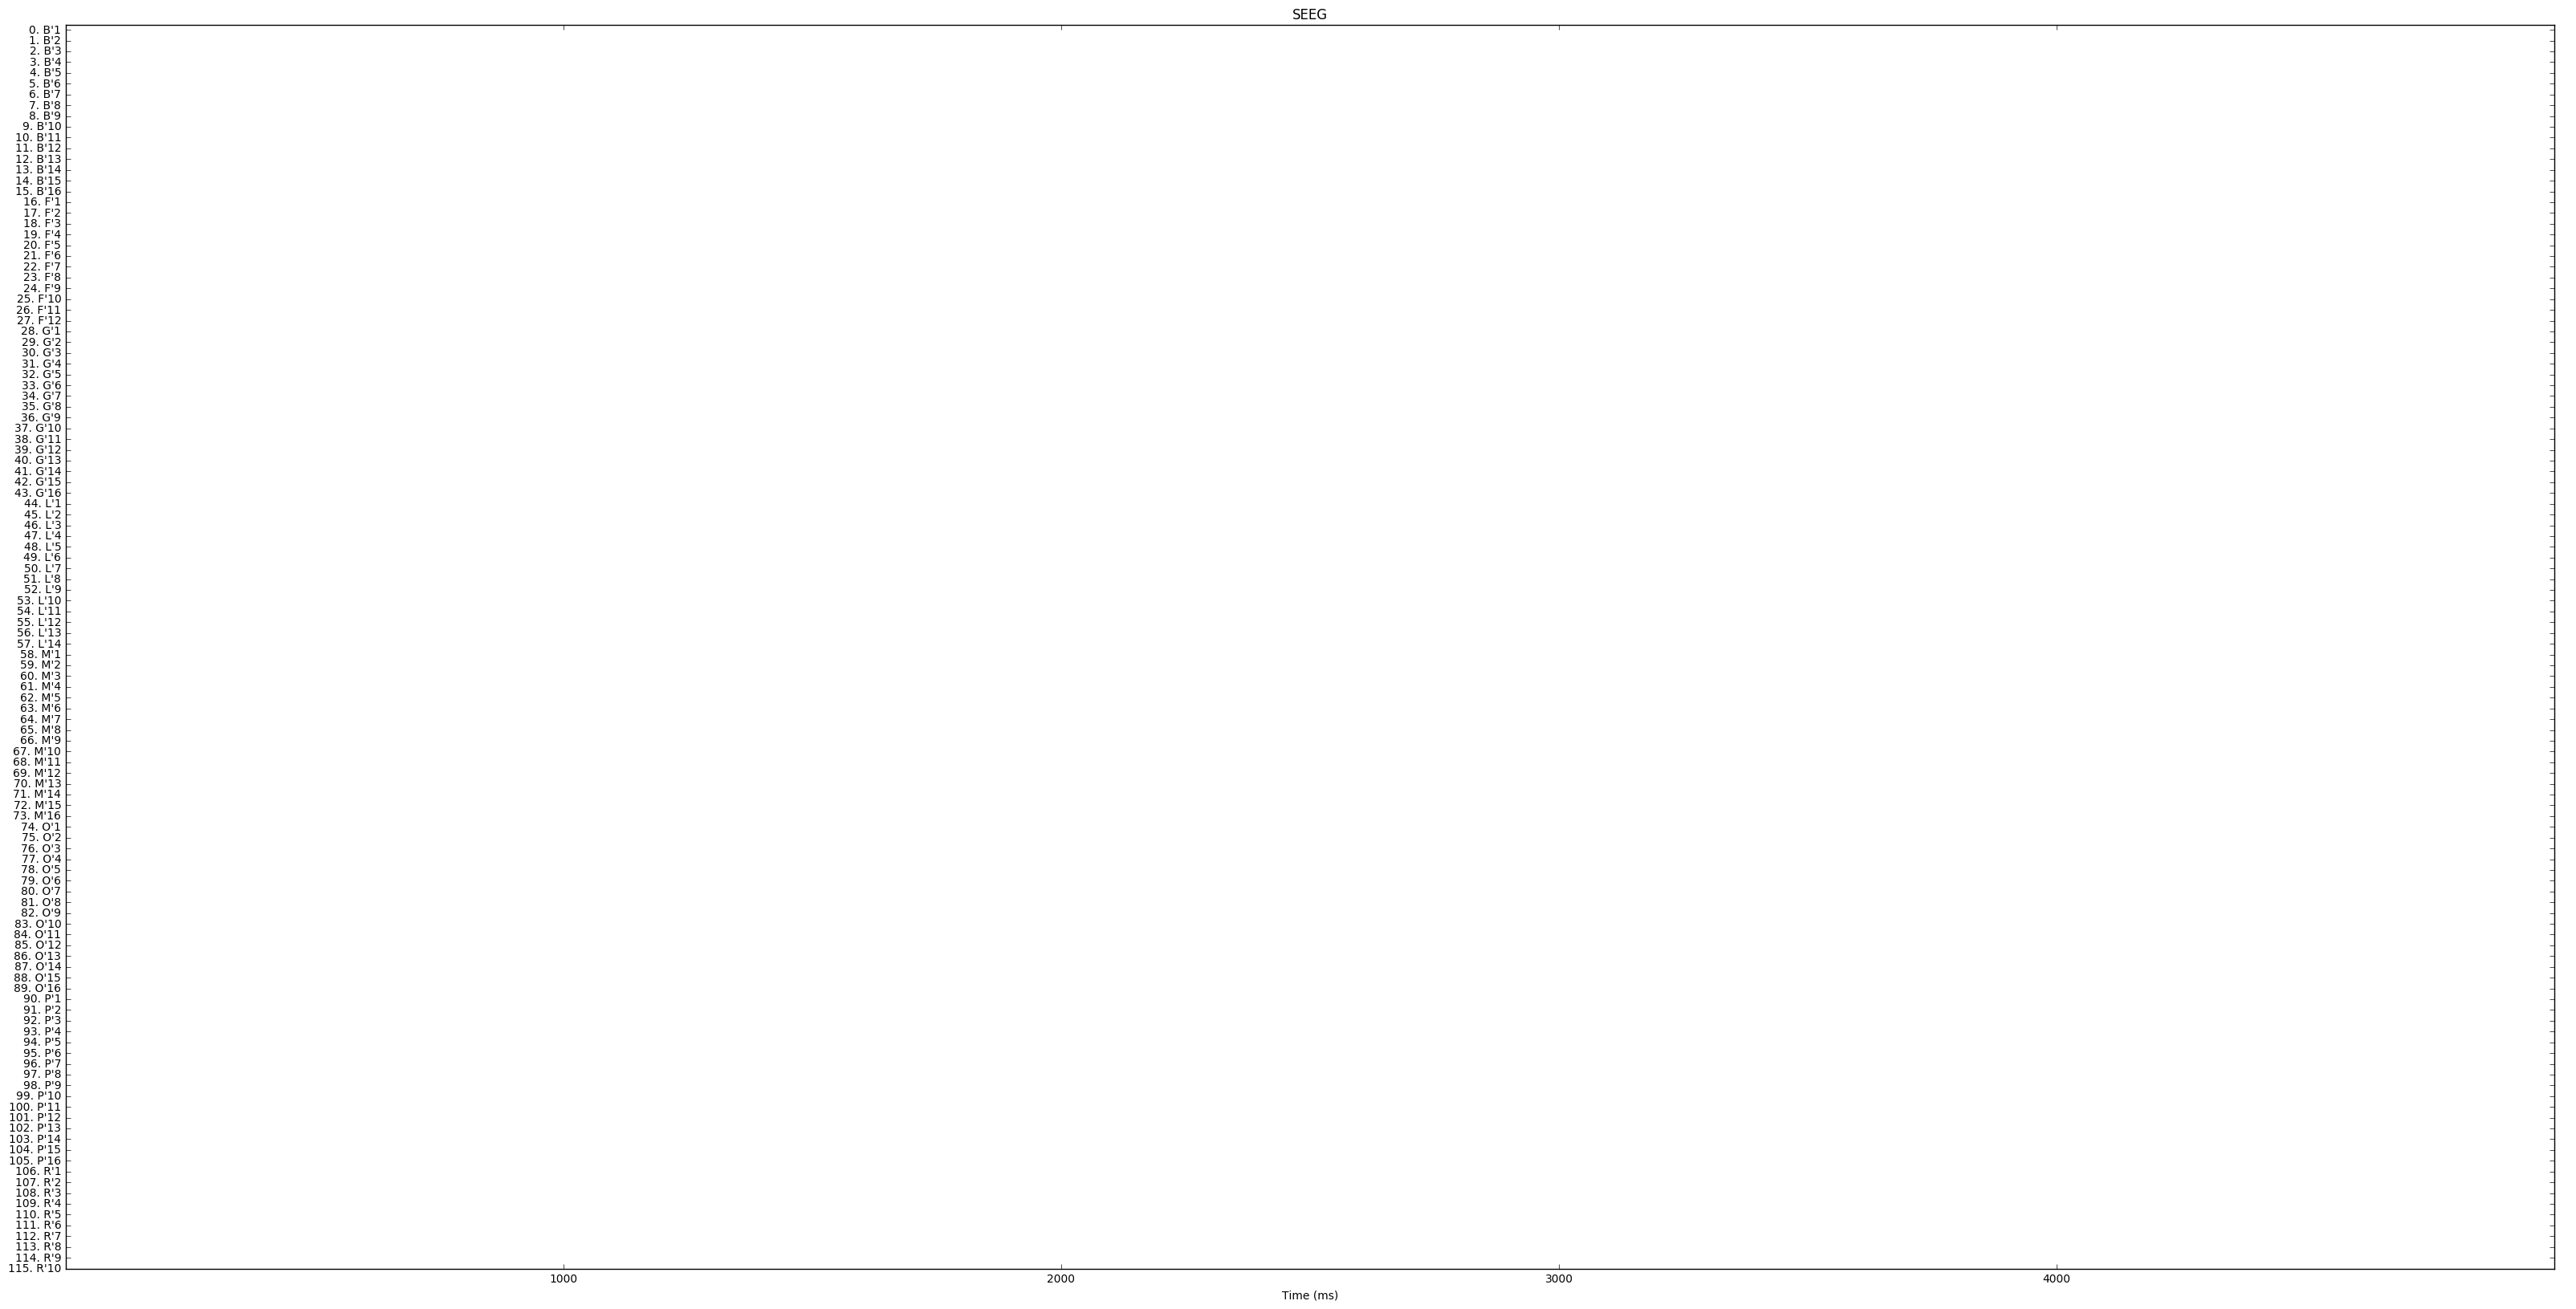

5120


In [45]:
# Integrator and initial conditions initialization.
# By default initial condition is set right on the equilibrium point.
logger.info("\n\nSimulating...")
sim_output = []
seeg=[]
sim_output, status = sim.launch_simulation(report_every_n_monitor_steps=100)
sim_ts_file =  os.path.join(config.out.FOLDER_RES, hypothesis.name + sim.model._ui_name + "_ts.h5")
if not status:
    logger.warning("\nSimulation failed!")
else:
    sim_output, seeg = \
        compute_seeg_and_write_ts_to_h5(sim_output, sim.model, head.sensorsSEEG, sim_ts_file,
                                        seeg_gain_mode="lin", hpf_flag=True, hpf_low=10.0, hpf_high=512.0)
     
    # Plot results 
    plotter.plot_simulated_timeseries(sim_output, sim.model, lsa_hypothesis.lsa_propagation_indices, 
                                      seeg_list=seeg, spectral_raster_plot=False, log_scale=True, title_prefix=hypothesis.name)
print(sim_output.time_length)